In [60]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer 
  
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/jayiraj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/jayiraj/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jayiraj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [61]:
df= pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [62]:
# Rename the columns
df = df.rename(columns={
    'emotion_in_tweet_is_directed_at': 'products',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'
})

df.head()

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [63]:
df2 = df.copy()

In [64]:
df['emotions'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotions, dtype: int64

In [65]:
df2

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [66]:
df = df[df['emotions'].isin(['Positive emotion', 'Negative emotion'])]



In [67]:
df['emotions'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotions, dtype: int64

In [68]:
df

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion


In [69]:
sw = stopwords.words('english')

In [70]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Text tokenization
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:'[a-z]+)?)")
df['tokenized_text'] = df['tweet_text'].apply(lambda x: tokenizer.tokenize(str(x).lower()))

# Stopword removal
stop_words = set(stopwords.words('english'))
#df['cleaned_text'] = df['tokenized_text'].apply(lambda x: [token for token in x if token not in stop_words])
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [token.replace(',', '') for token in x if token not in stop_words])


In [71]:
df

,tweet_text,products,emotions,tokenized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,"[mention, pr, guy, convinced, switch, back, ip..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,"[quot, papyrus, sort, like, ipad, quot, nice, ..."
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,"[diller, says, google, tv, quot, might, run, p..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,"[i've, always, used, camera, iphone, b, c, ima..."


In [72]:
from nltk import FreqDist
from itertools import chain

# Flatten the lists in the "tokenized_text" column
flat_tokenized_text_1 = list(chain.from_iterable(df["tokenized_text"]))

# Create FreqDist from the flattened list
freq_dist_1 = FreqDist(flat_tokenized_text_1)

freq_dist_1

FreqDist({'sxsw': 3739, 'mention': 2507, 'ipad': 1449, 'link': 1319, 'rt': 1075, 'apple': 1011, 'google': 830, 'iphone': 711, 'quot': 639, 'store': 596, ...})

In [73]:
# manual cleaning 
rem_t = ['sxsw', 'mention','link','rt', 'for', 'apple','quot','circles']
# Remove words in rem_t from 'tokenized_text'
df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: [word for word in tokens if word not in rem_t])


In [74]:
# Flatten the lists in the "tokenized_text" column
flat_tokenized_text_2 = list(chain.from_iterable(df["tokenized_text"]))

# Create FreqDist from the flattened list
freq_dist_2 = FreqDist(flat_tokenized_text_2)

freq_dist_2

FreqDist({'ipad': 1449, 'google': 830, 'iphone': 711, 'store': 596, 'app': 461, 'new': 403, 'austin': 323, 'amp': 233, 'android': 233, 'pop': 231, ...})

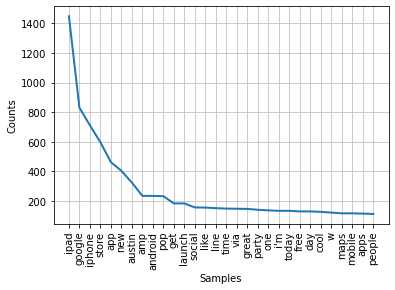

In [75]:
from itertools import chain

# Visualize the word frequencies using a bar plot
plt = freq_dist_2.plot(30, cumulative=False)


In [76]:
df['emotions'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotions, dtype: int64

In [77]:
# Map emotions to target values
emotion_mapping = {'Positive': 1, 'Negative': 0}
df['target'] = df['emotions'].map(emotion_mapping)


In [78]:
df['target'].value_counts()

Series([], Name: target, dtype: int64)

In [79]:
df['tweet_text'].isna().sum()

0

In [80]:
df['target'] = df['emotions'].apply(lambda x: 1 if x == 'Positive emotion' else (0 if x == 'Negative emotion' else None))


#df['target'].fillna(default_value, inplace=True)

In [81]:
# Lemmetization 

#s_stemmer = nltk.stem.SnowballStemmer(language='english')

In [82]:
# Apply stemming to all rows in the 'tokenized_text' column
#df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: [s_stemmer.stem(token) for token in tokens])


In [83]:
df

,tweet_text,products,emotions,tokenized_text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi...",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale]",1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year's, festival, crashy, year's, iphon...",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer,...",1
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,"[pr, guy, convinced, switch, back, iphone, gre...",1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,"[papyrus, sort, like, ipad, nice, lol, lavelle]",1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,"[diller, says, google, tv, might, run, playsta...",0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,"[i've, always, used, camera, iphone, b, c, ima...",1


In [84]:
flat_tokenized_text_3 = list(chain.from_iterable(df["tokenized_text"]))

# Create FreqDist from the flattened list
freq_dist_3 = FreqDist(flat_tokenized_text_3)

freq_dist_3

FreqDist({'ipad': 1449, 'google': 830, 'iphone': 711, 'store': 596, 'app': 461, 'new': 403, 'austin': 323, 'amp': 233, 'android': 233, 'pop': 231, ...})

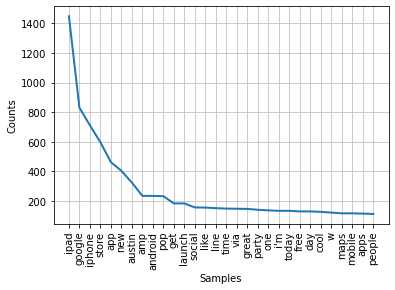

In [85]:
plt = freq_dist_3.plot(30, cumulative=False)

In [86]:
" ".join(df['tokenized_text'][0])

'wesley g iphone hrs tweeting rise austin dead need upgrade plugin stations'

## CountVectorizer

In [87]:
# Convert a collection of text documents to a matrix of token counts

#vec = CountVectorizer()
#X = vec.fit_transform([" ".join(df['tokenized_text'][0])])


#dfv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
#dfv.head()

In [88]:
df.tokenized_text

0       [wesley, g, iphone, hrs, tweeting, rise, austi...
1       [jessedee, know, fludapp, awesome, ipad, iphon...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, year's, festival, crashy, year's, iphon...
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9077    [pr, guy, convinced, switch, back, iphone, gre...
9079      [papyrus, sort, like, ipad, nice, lol, lavelle]
9080    [diller, says, google, tv, might, run, playsta...
9085    [i've, always, used, camera, iphone, b, c, ima...
9088                                   [ipad, everywhere]
Name: tokenized_text, Length: 3548, dtype: object

In [89]:
#vectorizing using parameters max_features
#df['tokenized_text'] = df['tokenized_text'].apply(lambda tokens: ' '.join(tokens))

# Create a CountVectorizer
#vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                     # stop_words=sw, ngram_range=(1, 2),
                      #max_features=200)
#X = vec.fit_transform(df['tokenized_text'])

# Create a DataFrame with the count vectorized features
#df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

# Display the DataFrame
#df_cv

IndentationError: unexpected indent (<ipython-input-89-22580437a3a8>, line 6)

vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=sw, ngram_range=(1, 2), max_features=200)
X = vec.fit_transform(df['tokenized_text'])

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
df_cv

## TfidfVectorizer

In [ ]:
#tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
#X = tf_vec.fit_transform(df['tokenized_text'])

#df_tv = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names_out())
#df_tv.head()

In [ ]:
#df_tv.iloc[1].sort_values(ascending=False)[:10]

In [ ]:
#df_cv.iloc[5].sort_values(ascending=False)[:5]

## Performing the split 


In [90]:
X = df[['tokenized_text']]
y= df['target']

In [91]:
X.shape

(3548, 1)

In [92]:
y

0       0
1       1
2       1
3       0
4       1
       ..
9077    1
9079    1
9080    0
9085    1
9088    1
Name: target, Length: 3548, dtype: int64

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [94]:
X_train

,tokenized_text
3944,"[they're, giving, away, ipad, x, boxes, books,..."
7306,"[setting, ipad, swift, upbeat, service, mornin..."
2730,"[third, time, charm, gt, gt, gt, google, launc..."
3568,"[used, think, started, making, great, apps, of..."
1146,"[hopefully, best, thing, comes, fact, people, ..."
...,...
2760,"[dear, could, roll, hot, dog, cart, full, ipad..."
3151,"[kick, sxswi, giving, away, ipad, visit, fb, p..."
2121,"[cnngrill, rockin, iphone, cooler]"
8989,"[crazy, much, culture, documented, google, doo..."


token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [95]:
#token_docs

In [96]:
#df['processed'] = df['tokenized_text'].apply(doc_preparer)
df.head()

,tweet_text,products,emotions,tokenized_text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[wesley, g, iphone, hrs, tweeting, rise, austi...",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[swonderlin, wait, ipad, also, sale]",1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year's, festival, crashy, year's, iphon...",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, marissa, mayer,...",1


In [97]:
#X_train['cleaned'] = X_train['tokenized_text'].apply(doc_preparer)
X_train['cleaned'] = X_train['tokenized_text']

<ipython-input-97-4b96e3ff5db1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cleaned'] = X_train['tokenized_text']


In [98]:
X_train.head()

,tokenized_text,cleaned
3944,"[they're, giving, away, ipad, x, boxes, books,...","[they're, giving, away, ipad, x, boxes, books,..."
7306,"[setting, ipad, swift, upbeat, service, mornin...","[setting, ipad, swift, upbeat, service, mornin..."
2730,"[third, time, charm, gt, gt, gt, google, launc...","[third, time, charm, gt, gt, gt, google, launc..."
3568,"[used, think, started, making, great, apps, of...","[used, think, started, making, great, apps, of..."
1146,"[hopefully, best, thing, comes, fact, people, ...","[hopefully, best, thing, comes, fact, people, ..."


## Model Evaluation vocabulary limitation (max_features=100)

In [99]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train['cleaned'], y_train,
                                          test_size=0.25, random_state=42)
#stopping our vectorizer at 200 features
cv = CountVectorizer(max_features=100)

X_t_vec = cv.fit_transform(X_t)
# transforming the return sparce matrix into a Dataframe
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
#giving the vocabulary as column
X_t_vec.columns = sorted(cv.vocabulary_)
#Using the index from our training data
X_t_vec.set_index(y_t.index, inplace=True)

# We then transform (vectorized) the validation set from our #segundary Split 
X_val_vec = cv.transform(X_val)

# transforming the return sparce matrix into a Dataframe
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)

#giving the vocabulary as column
X_val_vec.columns = sorted(cv.vocabulary_)
#Using the index from our training data
X_val_vec.set_index(y_val.index, inplace=True)

AttributeError: 'list' object has no attribute 'lower'

In [100]:
X_t_vec

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
7411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
cv.vocabulary_

AttributeError: 'CountVectorizer' object has no attribute 'vocabulary_'

In [102]:
X_val_vec

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
2932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Multinomial Naive Bayes

In [103]:
#Initiating the Multinomial Naive Bayes
mnb = MultinomialNB()

#fitting vectorized trainning sets
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [104]:
# Sanity check 
y_t.value_counts(normalize=True)

1    0.843108
0    0.156892
Name: target, dtype: float64

In [105]:
#empirical log probability for each class
mnb.class_log_prior_

array([-1.85219614, -0.17066049])

In [106]:
#np.exp(mnb.class_log_prior_[0])

In [107]:
#model Accuracy 
print(f'Just for 10 features (words) the model is {mnb.score(X_t_vec, y_t)} accurate')

Just for 10 features (words) the model is 0.9588972431077695 accurate


In [108]:
#Validation Score 
y_hat = mnb.predict(X_val_vec)


print(f'Just for 10 features (words) the model is validate at {accuracy_score(y_val, y_hat)} ')

Just for 10 features (words) the model is validate at 0.8543543543543544 


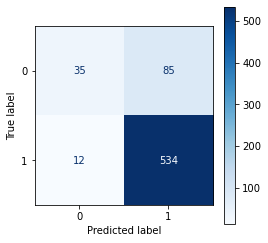

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix
cm1 = confusion_matrix(y_val, mnb.predict(X_val_vec))

# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=mnb.classes_)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".0f")

# Show the plot
plt.show()

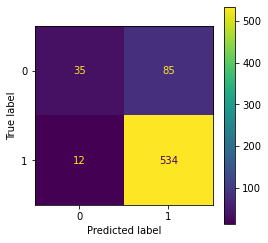

In [110]:
# Create the confusion matrix


# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels= mnb.classes_).plot(ax=ax)

# Show the plot
plt.show()

In [111]:
#Calculating the precision score
precision_score(y_val, y_hat)

0.8626817447495961

In [112]:
#Model Cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(mnb,X_t_vec, y_t).mean()

0.8395989974937343

## Summary

In [113]:
print ('For 10 words or features only here the results of our model')
print ('\n')
print(f'Accuracy: {accuracy_score(y_val, y_hat)}')
print(f'Precision: {precision_score(y_val, y_hat, average="weighted")}')
print (f'CrossValidation:{cross_val_score(mnb,X_t_vec, y_t).mean()}')
#print(f'Recall: {recall_score(y_val, y_hat)}')
#print(f'F1 Score: {f1_score(y_val, y_hat )}')

For 10 words or features only here the results of our model


Accuracy: 0.8543543543543544
Precision: 0.8414203224638725
CrossValidation:0.8395989974937343


## Binary Model Evaluation without vocabulary limitation 

In [114]:
#Model instantiation without specifying features limitations with max_features
cv = CountVectorizer()
#transforming training sets
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

#transforming validation sets
X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

AttributeError: 'list' object has no attribute 'lower'

In [115]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
cm= (mnb, X_t_vec, y_t);

In [116]:
precision_score(y_t, mnb.predict(X_t_vec))

0.9587155963302753

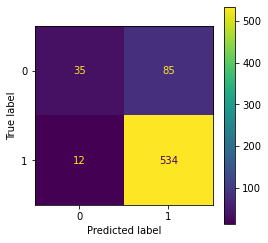

In [117]:
# Create the confusion matrix
cm2 = confusion_matrix(y_val, mnb.predict(X_val_vec))

# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels= mnb.classes_).plot(ax=ax)

# Show the plot
plt.show()

## Summary

In [118]:
print (' here the results of our model')
print ('\n')
print(f'Accuracy: {accuracy_score(y_val, y_hat)}')
print(f'Precision: {precision_score(y_val, y_hat, average="weighted")}')
print (f'CrossValidation:{cross_val_score(mnb,X_t_vec, y_t).mean()}')
#print(f'Recall: {recall_score(y_val, y_hat)}')
#print(f'F1 Score: {f1_score(y_val, y_hat )}')

 here the results of our model


Accuracy: 0.8543543543543544
Precision: 0.8414203224638725
CrossValidation:0.8395989974937343


## Comparaison with Random Forest

In [119]:
rf = RandomForestClassifier(n_estimators=800, max_depth=5)
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
precision_score(y_val, y_hat)


0.8198198198198198

In [120]:
precision_score(y_t, rf.predict(X_t_vec))

0.8431077694235589

In [121]:
len(rf.feature_importances_)

4239

In [122]:
dict(zip(list(X_t_vec.columns), rf.feature_importances_))

{'aapl': 0.0,
 'abacus': 0.0007257030655771727,
 'abandoned': 0.0005097153965786861,
 'aber': 0.0,
 'able': 0.0,
 'abroad': 0.0005363061727289825,
 'absolutely': 0.0,
 'abt': 0.0,
 'abuzz': 0.0,
 'academy': 0.0,
 'access': 0.0,
 'accessible': 0.0,
 'accessory': 0.0,
 'accesssxsw': 0.0,
 'accommodate': 0.0,
 'according': 0.00068643475212531,
 'accordion': 0.0,
 'account': 0.0,
 'acerbic': 0.000239414038831721,
 'achieve': 0.0,
 'acknowledge': 0.00047154427896645883,
 'aclu': 6.579559997251e-05,
 'acquired': 0.0004601979532742251,
 'across': 0.00015998535691327784,
 'acrosse': 0.0,
 'acting': 0.0,
 'action': 0.00018844519253884219,
 'activate': 0.0001887109455833272,
 'actsofsharing': 0.0,
 'actual': 0.0,
 'actually': 0.0,
 'ad': 0.0,
 'adapt': 0.0,
 'adaptive': 0.0,
 'add': 0.0,
 'added': 0.0,
 'addicted': 0.0,
 'addictedtotheinterwebs': 0.0,
 'addiction': 0.0,
 'addictive': 0.0,
 'addicts': 0.0005515560892313503,
 'addition': 0.0,
 'additional': 0.0,
 'admired': 0.0,
 'admission': 0.0,

In [123]:
#X_train

In [124]:
X_t_vec

,aapl,abacus,abandoned,aber,able,abroad,absolutely,abt,abuzz,academy,...,zazzlsxsw,zero,zimride,zing,zite,zms,zombies,zomg,zoom,zzzs
7411,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
df2

,tweet_text,products,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [126]:
df2['emotions'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotions, dtype: int64

In [127]:
df2['emotions'] = df2['emotions'].replace('No emotion toward brand or product', 'Neutral')
df2['emotions'] = df2['emotions'].replace('Positive emotion', 'Positive')
df2['emotions'] = df2['emotions'].replace('Negative emotion', 'Negative')

In [128]:
df2 = df2[df2['emotions'].isin(['Neutral', 'Negative', 'Positive'])]

In [159]:
df2['emotions'].value_counts(normalize=True)

Neutral     0.602954
Positive    0.333259
Negative    0.063787
Name: emotions, dtype: float64

In [130]:
# Map emotions to target values
#emotion_mapping = {'No emotion': 2,'Positive emotion': 1, 'Negative emotion': 0}
#df2['target'] = df2['emotions'].map(emotion_mapping)
df2['target'] = df2['emotions']

<ipython-input-130-aeb28ddccd20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['target'] = df2['emotions']


In [131]:
df2['target'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: target, dtype: int64

In [132]:
df2.isna().sum()

tweet_text       1
products      5655
emotions         0
target           0
dtype: int64

In [133]:
df2 = df2.dropna(subset=['tweet_text'])

In [134]:
df2.isna().sum()

tweet_text       0
products      5654
emotions         0
target           0
dtype: int64

In [135]:
# Bring in stopwords

sw = stopwords.words('english')

In [136]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [137]:
lemmatizer = WordNetLemmatizer() 

In [138]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: column from database
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

##  Model with Multiclass classification without class weights 

In [231]:
X= df2[['tweet_text']]
y= df2['target']
y

0       Negative
1       Positive
2       Positive
3       Negative
4       Positive
          ...   
9088    Positive
9089     Neutral
9090     Neutral
9091     Neutral
9092     Neutral
Name: target, Length: 8936, dtype: object

In [140]:
X.shape

(8936, 1)

In [141]:
y.shape

(8936,)

In [142]:
y.value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: target, dtype: int64

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25)

In [144]:
X_train.isna().sum()

tweet_text    0
dtype: int64

In [145]:
X_t, X_val, y_t, y_val = train_test_split(X_train['tweet_text'], y_train,
                                          test_size=0.25, random_state=42)

In [146]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95, 
                preprocessor=doc_preparer)
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnba = MultinomialNB()

mnba.fit(X_t_vec, y_t)
y_hat = mnba.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/jayiraj/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5404818203247002

In [147]:
cm2 = confusion_matrix(y_val, mnba.predict(X_val_vec))

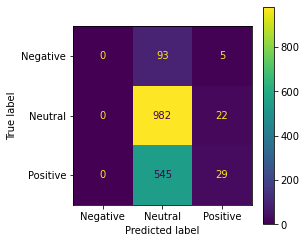

In [148]:
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels= mnba.classes_).plot(ax=ax)

# Show the plot
plt.show()

## Features importances

In [ ]:
#pd.DataFrame.sparse.from_spmatrix(X_t_vec, columns=tfidf.get_feature_names_out())

## Comparaison with Random Forest

In [223]:
rf = RandomForestClassifier(n_estimators=800, max_depth=5, class_weight = 'balanced')
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
precision_score(y_val, y_hat, average='weighted')

0.585780649638548

In [228]:
feature_importances = rf.feature_importances_
feature_importances
num_features = len(feature_importances)
num_features

23

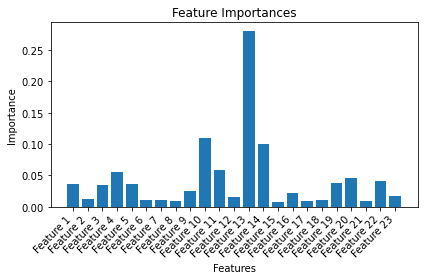

In [230]:
features = [f"Feature {i+1}" for i in range(len(feature_importances))]
plt.bar(features, feature_importances)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


##  Model with Multiclass classification with class weights 

In [194]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95, 
                preprocessor=doc_preparer)
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_t), y_t)
np.array(class_weights)

mnba = MultinomialNB()

mnba.fit(X_t_vec, y_t, sample_weight= class_weights)
y_hat = mnba.predict(X_val_vec)

precision_score(y_val, y_hat, average = 'weighted')

#mnba.fit(X_t_vec, y_t)
#y_hat = mnba.predict(X_val_vec)

#precision_score(y_val, y_hat, average='weighted')

/Users/jayiraj/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=['Negative' 'Neutral' 'Positive'], y=989     Negative
1960     Neutral
2048    Positive
5011     Neutral
4243    Positive
          ...   
7549     Neutral
2065     Neutral
4427    Negative
1405     Neutral
8241    Positive
Name: target, Length: 5026, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


ValueError: sample_weight.shape == (3,), expected (5026,)!

In [150]:
cm3 = confusion_matrix(y_val, mnba.predict(X_val_vec))
# Plot the Confusion Matrix with a smaller size
fig, ax = plt.subplots(figsize=(4, 4))  
ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels= mnba.classes_).plot(ax=ax)

# Show the plot
plt.show()

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Model Evaluation on the Test Set

In [77]:
X_val


2932    ha comes cool technology one's ever heard go c...
5305    look blue hair i've got free android phone inf...
3129    novelty ipad news apps fades fast among digita...
3934    mayer admits google needs step one one custome...
3964    html shirt google saying easeljs favorite canv...
                              ...                        
2776                              genius idea popup store
1778    ipad goes sale next friday austin store going ...
1676    airline mentioned guy kawasaki delightful like...
236                    meant also wish dyac stupid iphone
2938    lol comes cool technology one's ever heard go ...
Name: cleaned, Length: 666, dtype: object

X_val_df = pd.DataFrame(X_val_vec.toarray(), columns=tfidf.get_feature_names_out())
final_X_test = pd.concat([
    X_val_df, X_t[["num_sentences", "contains_price", "contains_emoticon"]]
], axis=1)
final_X_test